In [4]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import regularizers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

**LOAD DATASET**

In [5]:
# load the csv with patient data
alzheimers_df = pd.read_csv("alzheimers_disease_data.csv")

# remove the doctor in charge and patient ID column
alzheimers_df.drop(columns=['DoctorInCharge', 'PatientID'], inplace=True)

print(alzheimers_df.head())

   Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0   73       0          0               2  22.927749        0   
1   89       0          0               0  26.827681        0   
2   73       0          3               1  17.795882        0   
3   74       1          0               1  33.800817        1   
4   89       0          0               0  20.716974        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  ...  \
0           13.297218          6.327112     1.347214      9.025679  ...   
1            4.542524          7.619885     0.518767      7.151293  ...   
2           19.555085          7.844988     1.826335      9.673574  ...   
3           12.209266          8.428001     7.435604      8.392554  ...   
4           18.454356          6.310461     0.795498      5.597238  ...   

   FunctionalAssessment  MemoryComplaints  BehavioralProblems       ADL  \
0              6.518877                 0                   0  1.725883   
1       

**CHECK DATASET CHARACTERISTICS**

In [6]:
print(f"Shape: {alzheimers_df.shape}\n\n")
print(f"Total Null Values:\n{alzheimers_df.isnull().sum()}\n\n")

Shape: (2149, 33)


Total Null Values:
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0


In [7]:
print(f"Class Spreads:\n{alzheimers_df['Diagnosis'].value_counts(normalize=True)}\n\n")
print(f"Summary stats:\n{alzheimers_df.describe()}\n\n")

Class Spreads:
Diagnosis
0    0.646347
1    0.353653
Name: proportion, dtype: float64


Summary stats:
               Age       Gender    Ethnicity  EducationLevel          BMI  \
count  2149.000000  2149.000000  2149.000000     2149.000000  2149.000000   
mean     74.908795     0.506282     0.697534        1.286645    27.655697   
std       8.990221     0.500077     0.996128        0.904527     7.217438   
min      60.000000     0.000000     0.000000        0.000000    15.008851   
25%      67.000000     0.000000     0.000000        1.000000    21.611408   
50%      75.000000     1.000000     0.000000        1.000000    27.823924   
75%      83.000000     1.000000     1.000000        2.000000    33.869778   
max      90.000000     1.000000     3.000000        3.000000    39.992767   

           Smoking  AlcoholConsumption  PhysicalActivity  DietQuality  \
count  2149.000000         2149.000000       2149.000000  2149.000000   
mean      0.288506           10.039442          4.920202 

**NORMALIZE COLUMNS**

In [8]:
# want to normalize continous numeric columns
columns_to_normalize = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
                        'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
                        'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
                        'MMSE', 'FunctionalAssessment', 'ADL']

# initialize standard scaler from sklearn
scaler = StandardScaler()

# normalize
alzheimers_df_normalized = alzheimers_df
alzheimers_df_normalized[columns_to_normalize] = scaler.fit_transform(alzheimers_df[columns_to_normalize])

print(alzheimers_df_normalized.head())

        Age  Gender  Ethnicity  EducationLevel       BMI  Smoking  \
0 -0.212368       0          0               2 -0.655225        0   
1  1.567757       0          0               0 -0.114751        0   
2 -0.212368       0          3               1 -1.366428        0   
3 -0.101111       1          0               1  0.851625        1   
4  1.567757       0          0               0 -0.961607        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  ...  \
0            0.565923          0.492525    -1.253593      1.119918  ...   
1           -0.954895          0.945093    -1.538442      0.056836  ...   
2            1.653006          1.023896    -1.088855      1.487380  ...   
3            0.376930          1.227995     0.839804      0.760833  ...   
4            1.461793          0.486696    -1.443293     -0.824566  ...   

   FunctionalAssessment  MemoryComplaints  BehavioralProblems       ADL  \
0              0.497506                 0                  

**SPLIT INTO FEATURES AND LABEL COLUMN**

In [9]:
# label = diagnosis
alzheimer_labels = alzheimers_df_normalized['Diagnosis'].to_numpy()

# features are everything else
alzheimer_features = alzheimers_df_normalized.drop(columns=['Diagnosis']).to_numpy()

**SPLIT DATASET INTO TRAIN, TEST, AND VALIDATION**

In [10]:
# use test size of 20%
x_train, x_test, y_train, y_test = train_test_split(alzheimer_features, alzheimer_labels, test_size=0.2)

**MODEL 1: LOGISTIC REGRESSION**

In [11]:
# initialize model and fit
lrg = LogisticRegression(C=0.5, max_iter=200)
lrg.fit(x_train, y_train)

# Predict on test set
y_pred = lrg.predict(x_test)

# Evaluate accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy: 0.8534883720930233


**MODEL 2: NEURAL NET**

In [12]:
fnn = Sequential()
fnn.add(Dense(128, input_shape=(x_train.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
fnn.add(Dropout(0.2))
fnn.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
fnn.add(Dropout(0.3))
fnn.add(Dense(32, activation='relu'))
fnn.add(Dropout(0.4))
fnn.add(Dense(16, activation='relu'))
fnn.add(Dropout(0.5))
fnn.add(Dense(1, activation='sigmoid'))

fnn.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = fnn.fit(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.5044 - loss: 0.8798 - val_accuracy: 0.6424 - val_loss: 0.7759
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6071 - loss: 0.7963 - val_accuracy: 0.6395 - val_loss: 0.7478
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6412 - loss: 0.7580 - val_accuracy: 0.7238 - val_loss: 0.6823
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7374 - loss: 0.6864 - val_accuracy: 0.7849 - val_loss: 0.6072
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7625 - loss: 0.6874 - val_accuracy: 0.7849 - val_loss: 0.5729
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7864 - loss: 0.6092 - val_accuracy: 0.8198 - val_loss: 0.5310
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8143 - loss: 0.5779 - val_accuracy: 0.8459 - val_loss: 0.5050
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8296 - loss: 0.5571 - val_accuracy: 0.8459 - val_los

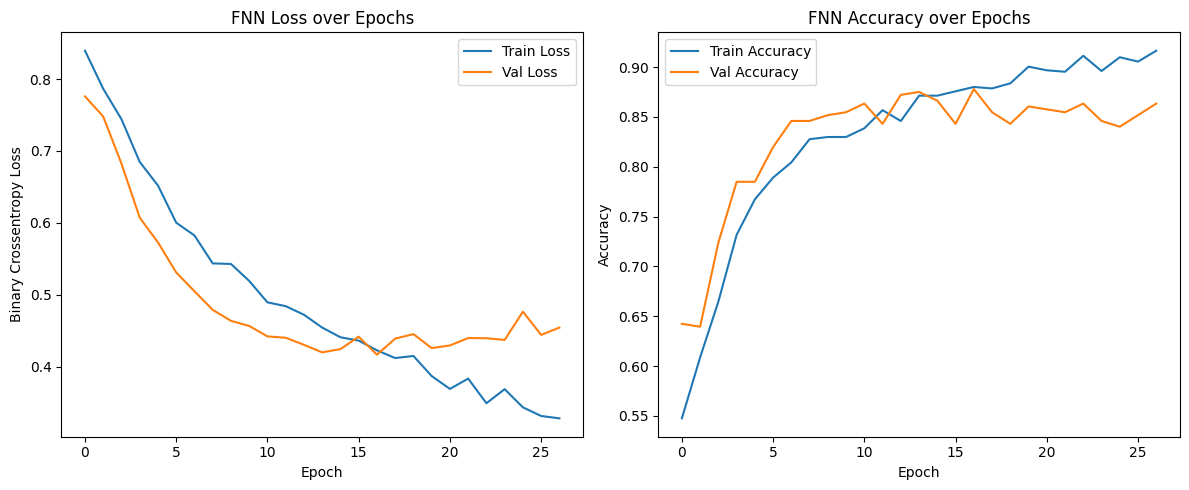

In [13]:
# plot training & validation loss
plt.figure(figsize=(12, 5))

# loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('FNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()

# accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('FNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


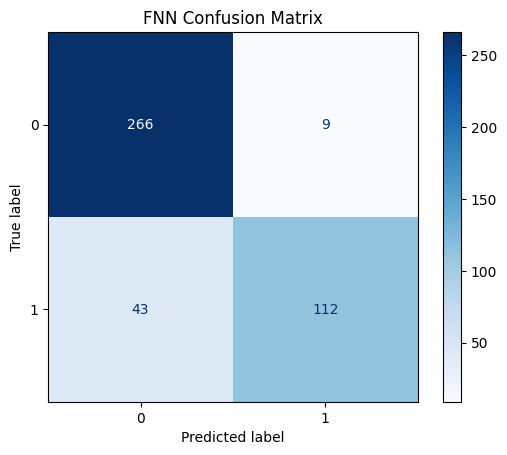

In [14]:
# predict test data
y_pred_prob = fnn.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('FNN Confusion Matrix')
plt.show()

In [15]:
print(f"Accuracy for FNN: {accuracy_score(y_test, y_pred)}")

Accuracy for FNN: 0.8790697674418605


**MODEL 3: RANDOM FOREST**

In [16]:
# train random forest
rf = RandomForestClassifier(n_estimators=500, random_state=42)
history = rf.fit(x_train, y_train)

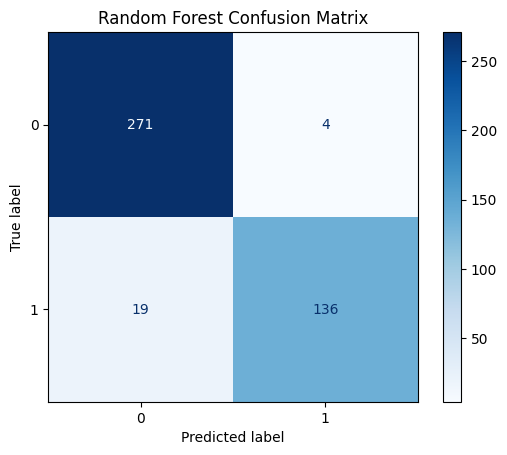

In [17]:
# predict on test set
rf_preds = rf.predict(x_test)

# plot confusion matrix
cm = confusion_matrix(y_test, rf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show()


In [18]:
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_preds)}")

Random Forest Accuracy: 0.9465116279069767


**MODEL 4: XGBoost**

In [19]:
# train xgb
xgb = XGBClassifier(n_estimators=500, max_depth=5, use_label_encoder=False, eval_metric='logloss', learning_rate=0.01)
xgb.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:24:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

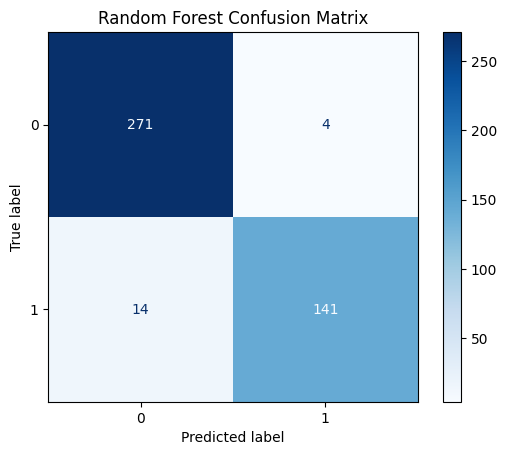

In [20]:
# get predictions on test set
xgb_preds = xgb.predict(x_test)

# plot confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show()


In [21]:
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_preds)}")

XGBoost Accuracy: 0.958139534883721


**MODEL 5: SVM**

In [22]:
# grid search to find best hyperparameters
parameters_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

grid = GridSearchCV(SVC(), parameters_grid, cv=5, scoring='accuracy')
grid.fit(x_train, y_train)

print("Best params:", grid.best_params_)
print("Best accuracy:", grid.best_score_)

Best params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best accuracy: 0.8458454810495628


In [23]:
# create SVM classifier with default RBF kernel
svm_model = SVC(kernel='rbf', C=100, gamma=0.001)

# Train the model
svm_model.fit(x_train, y_train)

SVC(C=100, gamma=0.001)

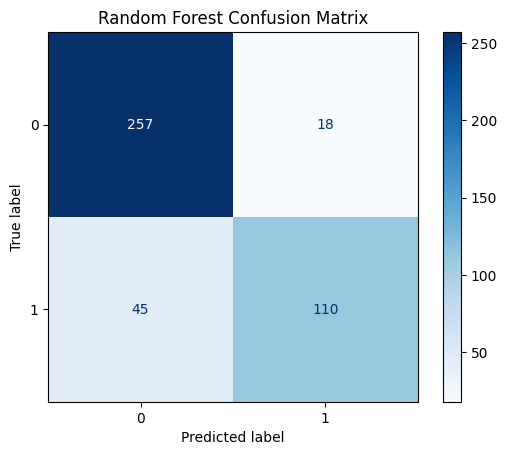

In [24]:
# get predictions on test set
svm_preds = svm_model.predict(x_test)

# plot confusion matrix
cm = confusion_matrix(y_test, svm_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show()


In [25]:
print(f"SVM Accuracy: {accuracy_score(y_test, svm_preds)}")

SVM Accuracy: 0.8534883720930233


In [26]:
svm_acc = accuracy_score(y_test, svm_preds)
lrg_acc = accuracy_score(y_test, y_pred)
rf_acc = accuracy_score(y_test, rf_preds)
xgb_acc = accuracy_score(y_test, xgb_preds)

In [27]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pandas as pd

pipelines = {
    'RandomForest': Pipeline([
        ('pca', PCA()),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'LogisticRegression': Pipeline([
        ('pca', PCA()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'SVM': Pipeline([
        ('pca', PCA()),
        ('clf', SVC(random_state=42))
    ])
}

param_grids = {
    'RandomForest': {
        'pca__n_components': [5, 10, 15, 20, 0.95],
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 5, 10]
    },
    'LogisticRegression': {
        'pca__n_components': [5, 10, 15, 20, 0.95],
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    },
    'SVM': {
        'pca__n_components': [5, 10, 15, 20, 0.95],
        'clf__C': [0.1, 1, 10],
        'clf__gamma': ['scale', 'auto'],
        'clf__kernel': ['rbf']
    }
}

results = []
for name, pipe in pipelines.items():
    grid = GridSearchCV(pipe,
                        param_grids[name],
                        cv=5,
                        scoring='accuracy',
                        n_jobs=-1,
                        verbose=1)
    grid.fit(x_train, y_train)
    results.append({
        'Model': name,
        'Best CV Score': grid.best_score_,
        'Best Parameters': grid.best_params_
    })

results_df = pd.DataFrame(results).set_index('Model')


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [28]:
# Model Accuracies w/o PCA Vs. Model Accuracies w/PCA
print("Model Accuracies w/o PCA:")
print(f"Logistic Regression Accuracy: {lrg_acc}")
print(f"Random Forest Accuracy: {rf_acc}")
print(f"XGBoost Accuracy: {xgb_acc}")

print("\nModel Accuracies w/PCA:")
print(results_df)



Model Accuracies w/o PCA:
Logistic Regression Accuracy: 0.8790697674418605
Random Forest Accuracy: 0.9465116279069767
XGBoost Accuracy: 0.958139534883721

Model Accuracies w/PCA:
                    Best CV Score  \
Model                               
RandomForest             0.779536   
LogisticRegression       0.809201   
SVM                      0.815008   

                                                      Best Parameters  
Model                                                                  
RandomForest        {'clf__max_depth': None, 'clf__n_estimators': ...  
LogisticRegression  {'clf__C': 10, 'clf__penalty': 'l2', 'clf__sol...  
SVM                 {'clf__C': 1, 'clf__gamma': 'scale', 'clf__ker...  
